In [1]:
import IPython as IP
IP.get_ipython().magic('reset -sf')
import numpy as np
import time as time
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.close('all')
import control
from control import *

In [2]:
def BioPlant_GR_TF():
    A_gr=[[0,-0.068],[-0.75,-0.1302]]
    B_gr=[[-0.9951],[2.4878]]
    C_gr=[1,0]
    D_gr=[0]
    TF_gr=control.ss2tf(A_gr, B_gr, C_gr, D_gr)
    return TF_gr

In [3]:
def BioPlant_ST_TF():
    A_st=[[0, 0.9056], [-0.75, -2.564]]
    B_st=[[-1.5301],[3.8255]]
    C_st=[1,0]
    D_st=[0]
    TF_st=control.ss2tf(A_st, B_st, C_st, D_st)
    return TF_st

In [4]:
def Result_Plotter(Time,yout):
    plt.plot(Time, yout)
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')
    plt.title('Step response for BioPlant controller')
    plt.grid()

In [5]:
def PID_TF_Generator(D,P,I):
    PID_Num=[D,P,I]
    PID_Den=[1,0]
    PID_TF=control.tf(PID_Num,PID_Den)
    return PID_TF

In [6]:
def PID_Plant_Response(PID_TF,TF_gr):
    FeedBack = feedback(PID_TF*TF_gr,1)
    Time=list(np.arange(0,40,0.1))
    Time, yout = control.step_response(sys=FeedBack,T=Time,X0=0)
    return Time,yout

In [7]:
def BioPlant_Error_Generator(D,P,I):
    TF_gr=BioPlant_GR_TF()
    w1=5
    w2=5
    w3=0
    w4=1
    w5=4
    w6=0

    PID_TF=PID_TF_Generator(D,P,I)
    Time,yout=PID_Plant_Response(PID_TF,TF_gr)

    Yout_np=np.array(yout.copy())
    Error=1-Yout_np
    Absolute_Error=np.abs(Error)
    Square_Error=Error**2
    Overshoot=np.max(Yout_np)-1

    Overshoot_Index=np.where(Yout_np==(1+Overshoot))[0]
    Overshoot_location=np.argmax(yout)/10
    #Sliced_Square_Error=Square_Error[:Overshoot_Index[0]]
    #Rise_Time_Index=np.where(Sliced_Square_Error==(np.min(Sliced_Square_Error)))
    
    #Rise_Time=Time[Rise_Time_Index][0]
    Rise_Time=0
    IAE = np.trapz(Absolute_Error, dx=0.01)
    ISE = np.trapz(Square_Error, dx=0.01)
    ITAE = np.trapz((Time*Absolute_Error), dx=0.01)
    ITSE = np.trapz((Time*Square_Error), dx=0.01)

    W=w1*IAE+w2*ISE+w3*ITAE+w4*ITSE+w5*Rise_Time+w6*Overshoot
    return W,yout,Time,IAE,ISE,ITAE,ITSE,Rise_Time,Overshoot

In [8]:
def Particle_Initial_Vel_Pos(swarm_size,dimensions,problem_boundary):
    particle_location = (np.random.rand(swarm_size,dimensions)-0.5)*problem_boundary*2   
    particle_velocity = np.random.rand(swarm_size,dimensions)
    return  particle_location,particle_velocity

In [9]:
def Particle_best_params(particle_location):    
    Particle_X=particle_location[:,0]
    Particle_Y=particle_location[:,1]
    Particle_Z=particle_location[:,2]
    particle_best_value=[]
    for particle in range(len(particle_location)):
        particle_value,*_=BioPlant_Error_Generator(Particle_X[particle],Particle_Y[particle],Particle_Z[particle])
        particle_best_value.append(particle_value)
    particle_best_location = np.copy(particle_location)
        
    return particle_best_value,particle_best_location

In [10]:
def Global_best(particle_best_value):
    PSO_best_value = np.min(particle_best_value)
    PSO_best_location = particle_location[np.argmin(particle_best_value)].copy()
    return PSO_best_value,PSO_best_location

In [11]:
def create_population(population_size, parameters, sub_chromosome_length,problem_boundary):

    
    population_sub1_ = np.random.uniform(-problem_boundary[0], problem_boundary[0], size=(population_size, 1))
    population_sub2_ = np.random.uniform(-problem_boundary[1], problem_boundary[1], size=(population_size, 1))
    population_sub3_ = np.random.uniform(-problem_boundary[2], problem_boundary[2], size=(population_size, 1))
    sub_chromosome_matrix=np.ones((population_size,sub_chromosome_length))/sub_chromosome_length
    
    population_sub1=population_sub1_*sub_chromosome_matrix
    population_sub2=population_sub2_*sub_chromosome_matrix
    population_sub3=population_sub3_*sub_chromosome_matrix
    
    population_sub12=np.hstack((population_sub1,population_sub2))
    population=np.hstack((population_sub12,population_sub3))


    return population

In [12]:
def boundary_checker(population,parameters,sub_chromosome_length,problem_boundary):

    Feature1=population[:,0:sub_chromosome_length]
    Feature2=population[:,sub_chromosome_length:2*sub_chromosome_length]
    Feature3=population[:,2*sub_chromosome_length:]
    Initial_Length=len(population)

    
    P=np.sum(Feature1,keepdims=True,axis=1)
    maskP=np.abs(P)>problem_boundary[0]
    D=np.sum(Feature2,keepdims=True,axis=1)
    maskD=np.abs(D)>problem_boundary[1]
    I=np.sum(Feature3,keepdims=True,axis=1)
    maskI=np.abs(I)>problem_boundary[2]
    maskPD=np.hstack((maskP,maskD))
    maskPDI=np.hstack((maskPD,maskI))
    
    
    mask=np.invert(np.any(maskPDI,axis=1))
    population_checked=population[mask]

    return population_checked

In [13]:
def calculate_fitness(population_checked,sub_chromosome_length):
    
    Feature1=population_checked[:,0:sub_chromosome_length]
    Feature2=population_checked[:,sub_chromosome_length:2*sub_chromosome_length]
    Feature3=population_checked[:,2*sub_chromosome_length:]

    X=(np.sum(Feature1,axis=1)).tolist()
    Y=(np.sum(Feature2,axis=1)).tolist()
    Z=(np.sum(Feature3,axis=1)).tolist()

    GA_Errors=[]
    for ns in range(len(X)):
        TTTT,*_=BioPlant_Error_Generator(X[ns],Y[ns],Z[ns])
        GA_Errors.append(TTTT)
    GA_Errors=np.reshape(GA_Errors,newshape=(np.shape(population_checked)[0],1))
    population_with_fitness=np.hstack((GA_Errors,population_checked))
        
    return population_with_fitness

In [14]:
def chromosome_to_result(Champ,sub_chromosome_length):
    Champ1=Champ[1:]
    Feature_1=Champ1[0:sub_chromosome_length]
    Feature_2=Champ1[sub_chromosome_length:2*sub_chromosome_length]
    Feature_3=Champ1[2*sub_chromosome_length:]

    Champ_X=(np.sum(Feature_1)).tolist()
    Champ_Y=(np.sum(Feature_2)).tolist()
    Champ_Z=(np.sum(Feature_3)).tolist()
    Champ_W,Champ_yout,Champ_Time,*_=BioPlant_Error_Generator(Champ_X,Champ_Y,Champ_Z)
    
    return Champ_X,Champ_Y,Champ_Z,Champ_W,Champ_yout,Champ_Time

In [15]:
def sort_population(population_with_fitness,population_size):
    population_sorted_=population_with_fitness[population_with_fitness[:,0].argsort()]
    population_sorted=population_sorted_[:population_size]
    return population_sorted

In [16]:
def breed_by_crossover(parent_1, parent_2,crossovers):

    chromosome_length = len(parent_1)-1
    crossover_points = np.sort(np.random.choice(range(1,chromosome_length),size=crossovers,replace=False))
    parents=[parent_1,parent_2]
    j=0
    k=1
    for point in crossover_points:
        
        child1 = np.hstack((parents[0][0:point],parents[k][point:]))
        child2 = np.hstack((parents[1][0:point],parents[j][point:]))
        parents[0]=child1.copy()
        parents[1]=child2.copy()
        j,k=k,j
    children=np.vstack((parents[0],parents[1]))
    
    return children

In [17]:
def population_generator(population_sorted,population_size,mutation_rate,crossovers,mutation_per_chromosome):
    
    quarter_size=int(population_size/4)
    selected_index=np.random.permutation(2*quarter_size)
    parent_one_list=selected_index[0:quarter_size]
    parent_two_list=selected_index[quarter_size:]
    population_no_score=np.delete(population_sorted,0,axis=1)
    population_for_breeding=population_no_score[:2*quarter_size]

    for i in range(quarter_size):
        parent_1=population_for_breeding[parent_one_list[i],:]
        parent_2=population_for_breeding[parent_two_list[i],:]
        children=breed_by_crossover(parent_1, parent_2,crossovers)
        population_for_breeding=np.vstack((population_for_breeding,children))

    population_for_mutation=population_for_breeding.copy()
    population_after_mutation=randomly_mutate_population(population_for_mutation, mutation_rate,mutation_per_chromosome)
    population=population_after_mutation.copy()
    return population

In [18]:
def randomly_mutate_population(population_for_mutation, mutation_rate,mutation_per_chromosome):
    
    (people,chromosome_length)=np.shape(population_for_mutation)
    keep=1
    max_val=np.max(population_for_mutation)
    min_val=np.min(population_for_mutation)
    muts1=int(mutation_rate*people)
    mutation_people=np.random.choice(range(keep,people-keep),size=muts1,replace=False)

    for num in mutation_people:
        mutant_genes=np.random.choice(range(0,chromosome_length),size=mutation_per_chromosome,replace=False)
        for mutant_gene in mutant_genes:
            population_for_mutation[num,mutant_gene]=np.random.uniform(min_val, max_val)
    population_after_mutation=population_for_mutation.copy()
    return population_after_mutation

In [19]:
def Result_Plotter(Time,yout):
    plt.plot(Time, yout)
    plt.xlabel('Time [hours]')
    plt.ylabel('Amplitude')
    plt.title('Step response for Bio-plant controller')
    plt.show()

In [20]:
def result_to_chromosome(PSO_best_value,swarm_X,swarm_Y,swarm_Z,sub_chromosome_length):
    tiny_sub_chromosome1=[(swarm_X/sub_chromosome_length) for i in range(sub_chromosome_length)]
    tiny_sub_chromosome2=[(swarm_Y/sub_chromosome_length) for i in range(sub_chromosome_length)]
    tiny_sub_chromosome3=[(swarm_Z/sub_chromosome_length) for i in range(sub_chromosome_length)]
    swarm=[PSO_best_value]+tiny_sub_chromosome1+tiny_sub_chromosome2+tiny_sub_chromosome3
    
    return swarm

In [21]:
def GA_Iterator(sub_chromosome_length,population_size,maximum_generation,problem_boundary,parameters,\
                mutation_rate,chromosome_length,population_sorted,mutation_per_chromosome):
    for generation in range(maximum_generation):
    
        population=population_generator(population_sorted,population_size,mutation_rate,crossovers,mutation_per_chromosome)
        population_checked=boundary_checker(population,parameters,sub_chromosome_length,problem_boundary)
        population_with_fitness= calculate_fitness(population_checked,sub_chromosome_length)
        population_sorted=sort_population(population_with_fitness,population_size)
        
        GA_best_score = population_sorted[0,0]
        best_score_progress.append(GA_best_score)
    
        Champ=population_sorted[0]
        X,Y,Z,*_=chromosome_to_result(Champ,sub_chromosome_length)

    return X,Y,Z,GA_best_score,population_sorted,best_score_progress

In [22]:
def PSO_Iterator(swarm_size,inertia,dimensions,local_weight,global_weight,max_velocity,step_size,problem_boundary,\
                particle_location,particle_velocity,particle_best_value,particle_best_location,\
                PSO_best_value,PSO_best_location):
    
    for particle_i in range(swarm_size): 
        for dimension_i in range(dimensions): 
            u = np.random.rand(dimensions) 
            error_particle_best = particle_best_location[particle_i,dimension_i]-particle_location[particle_i,dimension_i]
            error_global_best = PSO_best_location[dimension_i]-particle_location[particle_i,dimension_i]            
            v_new = inertia*particle_velocity[particle_i,dimension_i] +local_weight*u[0]*error_particle_best +\
            global_weight*u[1]*error_global_best
      
            if v_new < -max_velocity:
                v_new = -max_velocity
            elif v_new > max_velocity:
                v_new = max_velocity

            
            l_new = particle_location[particle_i,dimension_i] + v_new*step_size
            
            if l_new < -problem_boundary[dimension_i]:
                l_new= -problem_boundary[dimension_i]
            elif l_new > problem_boundary[dimension_i]:
                l_new = problem_boundary[dimension_i]
                
            particle_location[particle_i,dimension_i] = l_new
            particle_velocity[particle_i,dimension_i] = v_new
        

            v,*_= BioPlant_Error_Generator(particle_location[particle_i,0],particle_location[particle_i,1],\
                                        particle_location[particle_i,2])

            if v < particle_best_value[particle_i]: 
                particle_best_value[particle_i]=v
                particle_best_location[particle_i,:] = particle_location[particle_i,:].copy()

            if v < PSO_best_value:
                PSO_best_value=v
                PSO_best_location = particle_location[particle_i,:].copy()
    return  particle_location,particle_velocity,particle_best_value,particle_best_location,PSO_best_value,\
            PSO_best_location,v


In [23]:
def see_if_PSO_needs_update(X,Y,Z,GA_best_score,PSO_best_location,PSO_best_value):
    if (GA_best_score<PSO_best_value):
        PSO_best_location[0]=X
        PSO_best_location[1]=Y
        PSO_best_location[2]=Z
        PSO_best_value,*_=BioPlant_Error_Generator(X,Y,Z)
    return PSO_best_location,PSO_best_value

In [24]:
def see_if_GA_needs_update(population_sorted,GA_best_score,PSO_best_location,PSO_best_value):
    if (PSO_best_value<GA_best_score):
        swarm_X=PSO_best_location[0].copy()
        swarm_Y=PSO_best_location[1].copy()
        swarm_Z=PSO_best_location[2].copy()
        swarm=[result_to_chromosome(PSO_best_value,swarm_X,swarm_Y,swarm_Z,sub_chromosome_length)]
        population_sorted=np.vstack((swarm,population_sorted))
        
    return population_sorted

In [25]:
def Plot_Error_Per_Generation(best_score_progress):
    plt.plot(best_score_progress)
    plt.xlabel('Generation')
    plt.ylabel('Lowest error')
    plt.show()

C:\Users\Dara\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in square
  app.launch_new_instance()
C:\Users\Dara\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: overflow encountered in multiply
C:\Users\Dara\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in multiply


solution at x=-1.54, y=-3.72 z=-1.55
global_best value is 0.2635525167997862


C:\Users\Dara\Anaconda3\envs\tensorflow\lib\site-packages\numpy\lib\function_base.py:4062: RuntimeWarning: overflow encountered in add
  ret = (d * (y[tuple(slice1)] + y[tuple(slice2)]) / 2.0).sum(axis)
C:\Users\Dara\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars


solution at x=-1.54, y=-3.72 z=-1.55
global_best value is 0.2635525167997862
solution at x=-1.54, y=-3.72 z=-1.55
global_best value is 0.2635525167997862
solution at x=-1.54, y=-3.72 z=-1.55
global_best value is 0.2635525167997862
solution at x=-1.54, y=-3.72 z=-1.55
global_best value is 0.2635525167997862
solution at x=-1.54, y=-3.72 z=-1.55
global_best value is 0.2635525167997862
solution at x=-1.54, y=-3.72 z=-1.55
global_best value is 0.2635525167997862
solution at x=-1.54, y=-3.72 z=-1.55
global_best value is 0.2635525167997862
solution at x=-1.55, y=-3.78 z=-1.55
global_best value is 0.2606556331009861
solution at x=-1.57, y=-3.81 z=-1.55
global_best value is 0.25916414563842816
solution at x=-1.57, y=-3.82 z=-1.55
global_best value is 0.2584275534092892
solution at x=-1.85, y=-3.80 z=-1.76
global_best value is 0.2452304436057012
solution at x=-1.71, y=-3.88 z=-1.77
global_best value is 0.24388106043671706
solution at x=-1.82, y=-3.93 z=-1.75
global_best value is 0.23991203623954

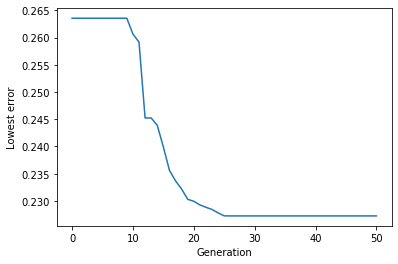

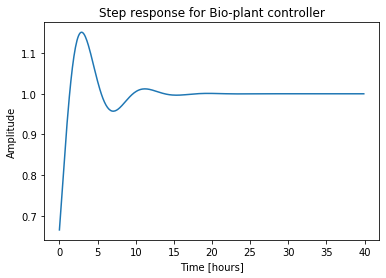

In [26]:
################################################   Hybrid Parameters      ##############################################
Combo_Iteration=50
problem_boundary=[2,4,2]
################################################   Hybrid Parameters      ##############################################



###########################    Particle Swarm Optimization Initialization Block      ###############################

swarm_size = 40                   
PSO_iterations = 1            
inertia = 0.5                    
dimensions = 3                   
local_weight = 2                  
global_weight =  2                 
max_velocity = 0.1                   
step_size = 1          

Track_keeper_Combo=[]

particle_location,particle_velocity=Particle_Initial_Vel_Pos(swarm_size,dimensions,problem_boundary)
particle_best_value,particle_best_location=Particle_best_params(particle_location)
PSO_best_value,PSO_best_location=Global_best(particle_best_value)
           

###########################    Particle Swarm Optimization Initialization Block      ###############################


################################    Genetic Algorithm Initialization Block      ####################################

sub_chromosome_length = 10
crossovers=5
population_size = 40
maximum_generation = 1
best_score_progress = []
parameters=3
chromosome_length=parameters*sub_chromosome_length
mutation_rate=0.05
mutation_per_chromosome=5

population = create_population(population_size, parameters, sub_chromosome_length,problem_boundary)
population_with_fitness= calculate_fitness(population,sub_chromosome_length)
population_sorted=sort_population(population_with_fitness,population_size)

GA_best_score = population_sorted[0,0]
best_score_progress.append(GA_best_score)
#population_with_fitness=[]


################################    Genetic Algorithm Initialization Block      ####################################


#####################################    Main PSO Body With Embeded GA     #########################################
for iteration_i in range(Combo_Iteration):
    
    X,Y,Z,GA_best_score,population_sorted,best_score_progress=GA_Iterator(sub_chromosome_length,population_size,\
                                                                          maximum_generation,problem_boundary,\
                                                                          parameters,mutation_rate,chromosome_length,\
                                                                          population_sorted,mutation_per_chromosome)
    

    PSO_best_location,PSO_best_value=see_if_PSO_needs_update(X,Y,Z,GA_best_score,PSO_best_location,PSO_best_value)
    
    particle_location,particle_velocity,particle_best_value,particle_best_location,PSO_best_value,PSO_best_location,\
    v=PSO_Iterator(swarm_size,inertia,dimensions,local_weight,global_weight,max_velocity,step_size,problem_boundary,\
                particle_location,particle_velocity,particle_best_value,particle_best_location,\
                PSO_best_value,PSO_best_location)
    
    population_sorted=see_if_GA_needs_update(population_sorted,GA_best_score,PSO_best_location,PSO_best_value)

    
    print('solution at x='+'%.2f' % PSO_best_location[0]+', y='+'%.2f' % PSO_best_location[1],\
         'z='+'%.2f' % PSO_best_location[2])
    print('global_best value is',PSO_best_value)
    Best_values_Combo=[iteration_i,PSO_best_location[0].copy(),PSO_best_location[1].copy(),PSO_best_location[2].copy()]
    Track_keeper_Combo.append(Best_values_Combo)

    
    
#####################################    Main PSO Body With Embeded GA     #########################################    

    
Plot_Error_Per_Generation(best_score_progress)
X_Combo=PSO_best_location[0]
Y_Combo=PSO_best_location[1]
Z_Combo=PSO_best_location[2]
W_Champ,yout_Champ,Time_Champ,IAE,ISE,ITAE,ITSE,Rise_Time,Overshoot=BioPlant_Error_Generator(X_Combo,X_Combo,X_Combo)
Result_Plotter(Time_Champ,yout_Champ)

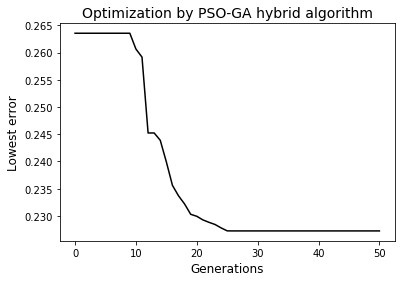

In [33]:
plt.plot(best_score_progress,'k')
plt.xlabel('Generations',fontsize=12)
plt.ylabel('Lowest error',fontsize=12)
plt.title('Optimization by PSO-GA hybrid algorithm',fontsize=14)
plt.savefig("Optimization by PSO-GA hybrid algorithm.png")
plt.show()

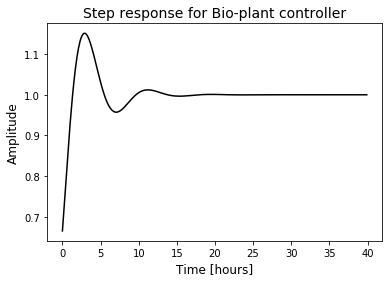

In [36]:
plt.plot(Time_Champ,yout_Champ,'k')
plt.xlabel('Time [hours]',fontsize=12)
plt.ylabel('Amplitude',fontsize=12)
plt.title('Step response for Bio-plant controller',fontsize=14)
plt.savefig("Response by PSO-GA hybrid algorithm.png")
plt.show()

In [1]:
print(best_score_progress)

NameError: name 'best_score_progress' is not defined